Optimization terminated successfully    (Exit mode 0)
            Current function value: 14763.056352359603
            Iterations: 2
            Function evaluations: 202
            Gradient evaluations: 2


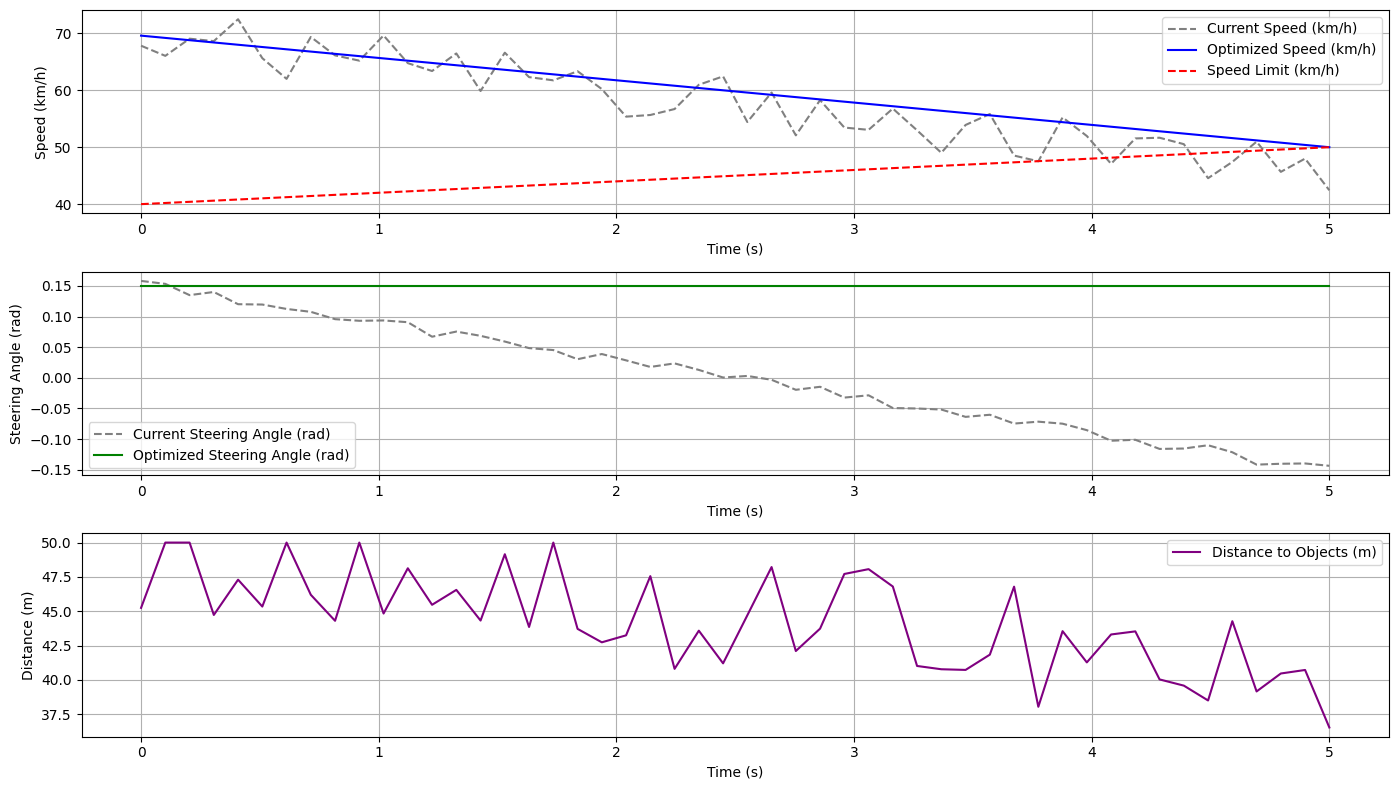

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Simulation Parameters
dt = 0.1  # Time step (s)
N = 50  # Prediction horizon
T = N * dt  # Total simulation time

# Vehicle Parameters
max_acceleration = 2.0  # m/s^2
min_acceleration = -4.0  # m/s^2
max_steering = np.radians(30)  # radians
max_steering_rate = np.radians(10)  # radians/s

# Initial Conditions
initial_speed = 70.0  # km/h
initial_position = np.array([0.0, 0.0])  # x, y
initial_steering_angle = 0.15  # radians

# Generate synthetic data
def generate_synthetic_data():
    time = np.linspace(0, T, N)
    speed_limit_data = np.linspace(40, 50, N)  # Dynamic speed limit
    current_speed_data = np.linspace(70, 45, N) + np.random.uniform(-5, 5, N)  # Dynamic current speeds
    position_x = np.cumsum(np.cos(initial_steering_angle) * current_speed_data * dt / 3.6)
    position_y = np.cumsum(np.sin(initial_steering_angle) * current_speed_data * dt / 3.6)
    steering_angle = np.clip(np.linspace(0.15, -0.15, N) + np.random.uniform(-0.01, 0.01, N), -max_steering, max_steering)
    distance_to_objects = np.clip(50 - 2 * time + np.random.uniform(-5, 5, N), 5, 50)  # Dynamic distances

    data = {
        "time": time,
        "speed_limit": speed_limit_data,
        "current_speed": current_speed_data,
        "position_x": position_x,
        "position_y": position_y,
        "steering_angle": steering_angle,
        "distance_to_objects": distance_to_objects,
    }
    return data

data = generate_synthetic_data()
time = data["time"]
speed_limit_data = data["speed_limit"]
current_speed_data = data["current_speed"]
position_x = data["position_x"]
position_y = data["position_y"]
steering_angle = data["steering_angle"]
distance_to_objects = data["distance_to_objects"]

# MPC Optimization
v = initial_speed  # Current speed (km/h)
delta = initial_steering_angle  # Current steering angle

def cost_fn(u):
    v_seq = np.clip(v + np.cumsum(u[:N] * dt), 0, None)  # Predicted speeds
    delta_seq = np.clip(delta + np.cumsum(u[N:] * dt), -max_steering, max_steering)  # Predicted steering angles
    speed_error = np.sum((v_seq - speed_limit_data) ** 2)
    steering_penalty = np.sum(u[N:] ** 2)
    distance_penalty = np.sum(1.0 / (distance_to_objects + 1e-6))  # Penalize proximity to objects
    return speed_error + 5 * steering_penalty + 10 * distance_penalty

u0 = np.zeros(2 * N)  # Initial guess for control inputs
bounds = [
    (min_acceleration, max_acceleration) if i < N else (-max_steering_rate, max_steering_rate)
    for i in range(2 * N)
]

result = minimize(
    cost_fn, u0, bounds=bounds, method="SLSQP", options={"disp": True}
)

if result.success:
    u_opt = result.x
    v_opt = np.clip(v + np.cumsum(u_opt[:N] * dt), 0, None)
    delta_opt = np.clip(delta + np.cumsum(u_opt[N:] * dt), -max_steering, max_steering)

    # Plot results
    plt.figure(figsize=(14, 8))

    # Speed plot
    plt.subplot(3, 1, 1)
    plt.plot(time, current_speed_data, label="Current Speed (km/h)", linestyle="--", color="gray")
    plt.plot(time, v_opt, label="Optimized Speed (km/h)", color="blue")
    plt.plot(time, speed_limit_data, label="Speed Limit (km/h)", color="red", linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (km/h)")
    plt.legend()
    plt.grid()

    # Steering angle plot
    plt.subplot(3, 1, 2)
    plt.plot(time, steering_angle, label="Current Steering Angle (rad)", linestyle="--", color="gray")
    plt.plot(time, delta_opt, label="Optimized Steering Angle (rad)", color="green")
    plt.xlabel("Time (s)")
    plt.ylabel("Steering Angle (rad)")
    plt.legend()
    plt.grid()

    # Distance to objects plot
    plt.subplot(3, 1, 3)
    plt.plot(time, distance_to_objects, label="Distance to Objects (m)", color="purple")
    plt.xlabel("Time (s)")
    plt.ylabel("Distance (m)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
else:
    print("Optimization failed. Check constraints or cost function.")


In [ ]:
print(synthetic_data)

{'Time Step (s)': array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
       0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
       1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
       1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
       2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
       2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ]), 'Speed Limit (km/h)': array([40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]), 'Current Speed (km/h)': array([70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
       70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70]), 'Position X (m)': array([1.92261043]), 'Position Y (m)': array([0.29057415]), 'Steering Angle (rad)': array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15,